## NOTLAR

* Test seti için değerleri oluştururken hangi idnin kaç ay işlem yaptığı, bu işlemleri hangi yılda yaptığı (2020de yapıp bitiridiyse 2023te işlem yapmıyor muhtemelen ama 2023te bitirdiyse işlem yapıyor olabilir)
* Ay sayısı eksik olan id'ler için eğer 2023 haricinde bittiyse işlemi 0 say.
* Elindeki dflerle mergele test seti ve featureları oluştur.
* 2023 ayında yeni işlem yapmaya başladıysa aksiyon alabilirsin.
* Churn'ü tanımla ve churn featureu ekle binary olarak.
* Müşteri yeni mi değil mi sütunu ekle.
* mevsimsel incele

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "C:\\Users\\ACER\\Desktop\\IYZICO\\"

df1 = pd.read_csv(path+"train.csv")
df1 = df1.sort_values(by=['merchant_id', 'month_id'])
df1['month_id'] = pd.to_datetime(df1['month_id'], format='%Y%m').dt.strftime('%Y-%m')
df1.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
234370,merchant_1,2021-08,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
234371,merchant_1,2022-10,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
249229,merchant_10,2021-11,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,6
249226,merchant_10,2021-12,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,24
249224,merchant_10,2022-01,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,15


### Müşteri İşlem Analizi

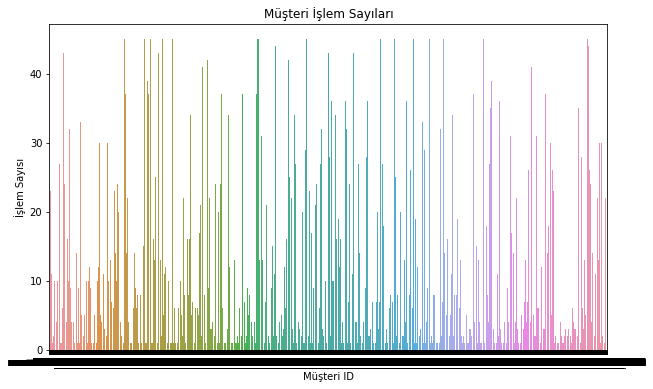

In [3]:
# Her müşterinin toplam işlem sayısını bulma
customer_transaction_counts = df1.groupby('merchant_id')['month_id'].count().reset_index()
customer_transaction_counts.columns = ['merchant_id', 'month_id']

# Müşteri davranışlarını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='merchant_id', y='month_id', data=customer_transaction_counts)
plt.title('Müşteri İşlem Sayıları')
plt.xlabel('Müşteri ID')
plt.ylabel('İşlem Sayısı')
plt.show()

### Churn Analizi

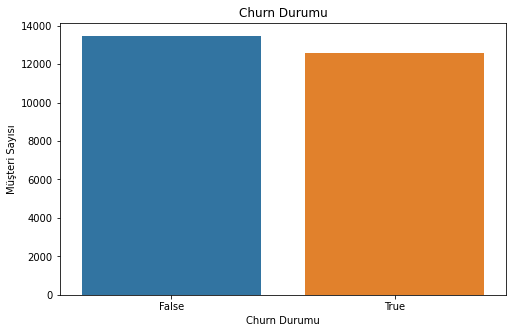

In [4]:
# Her müşterinin en son işlem tarihini bulma
last_transaction_date = df1.groupby('merchant_id')['month_id'].max().reset_index()

# Churn durumunu belirleme (bir süre işlem yapmayı bırakan müşterileri tespit etme)
churn_threshold = '2022-12' # Churn tarihini belirleme
last_transaction_date['churned'] = last_transaction_date['month_id'] < churn_threshold
# Churn durumu görselleştirme
plt.figure(figsize=(8, 5))
sns.countplot(x='churned', data=last_transaction_date)
plt.title('Churn Durumu')
plt.xlabel('Churn Durumu')
plt.ylabel('Müşteri Sayısı')
plt.show()

## İşlem Yapılmayan Ayların Tespiti, DataFrame' e Eklenmesi

In [5]:
months = [202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
          202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108,
          202109, 202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205, 202206,
          202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304,
          202305, 202306, 202307, 202308, 202309]

# Tüm müşteri ve tarih kombinasyonlarını içeren bir DataFrame oluşturulması
all_dates = pd.date_range(start=df1['month_id'].min(), end=df1['month_id'].max(), freq='M')
all_customers = pd.DataFrame({'merchant_id': df1['merchant_id'].unique()})
customer_dates = pd.DataFrame({'month_id': all_dates})
customer_dates['month_id'] = pd.to_datetime(customer_dates['month_id']).dt.strftime('%Y-%m')
customer_dates.loc[len(customer_dates.index)] = ['2023-09'] 

# Müşteri ve tarih kombinasyonlarına göre eksik tarihleri bulma ve DataFrame'e ekleme
result_df = pd.merge(all_customers, customer_dates, how='cross')
result_df = pd.merge(result_df, df1, how='left', on=['merchant_id', 'month_id'])

# İşlem yapılmayan ayları gösteren hedef sütununu ekme
result_df['net_payment_count'] = result_df['net_payment_count'].fillna(0).astype(int)

result_df["is_inactive"] = True
result_df['is_inactive'] = result_df['merchant_source_name'].isna()

result_df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive
0,merchant_1,2020-01,NaN,NaN,NaN,NaN,NaN,0,True
1,merchant_1,2020-02,NaN,NaN,NaN,NaN,NaN,0,True
2,merchant_1,2020-03,NaN,NaN,NaN,NaN,NaN,0,True
3,merchant_1,2020-04,NaN,NaN,NaN,NaN,NaN,0,True
4,merchant_1,2020-05,NaN,NaN,NaN,NaN,NaN,0,True
...,...,...,...,...,...,...,...,...,...
1172695,merchant_9993,2023-05,NaN,NaN,NaN,NaN,NaN,0,True
1172696,merchant_9993,2023-06,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4,False
1172697,merchant_9993,2023-07,NaN,NaN,NaN,NaN,NaN,0,True
1172698,merchant_9993,2023-08,NaN,NaN,NaN,NaN,NaN,0,True


In [6]:
for col in result_df.columns[2:7]:
    print(col)
    result_df[col] = result_df.groupby('merchant_id')[col].transform(lambda x: x.fillna(x.dropna().iloc[0]) if x.notnull().any() else x)
result_df

merchant_source_name
settlement_period
working_type
mcc_id
merchant_segment


,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True
...,...,...,...,...,...,...,...,...,...
1172695,merchant_9993,2023-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True
1172696,merchant_9993,2023-06,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4,False
1172697,merchant_9993,2023-07,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True
1172698,merchant_9993,2023-08,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True


In [7]:
result_df['is_customer'] = 0

for merchant_id, group in result_df.groupby('merchant_id'):
    # is_churn sütununda ilk 0 değerini bulalım
    first_churn_index = group[group['is_inactive'] == False].index.min()
    if pd.notna(first_churn_index):
        # ilk 0 değerinden sonraki satırları is_customer sütununa 1 olarak ayarlayalım
        first_churn_loc = result_df.index.get_loc(first_churn_index)
        result_df.loc[result_df.index >= first_churn_loc, 'is_customer'] = 1

result_df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
...,...,...,...,...,...,...,...,...,...,...
1172695,merchant_9993,2023-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True,1
1172696,merchant_9993,2023-06,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,4,False,1
1172697,merchant_9993,2023-07,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True,1
1172698,merchant_9993,2023-08,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,0,True,1


In [8]:
result_df.loc[result_df["merchant_id"] == "merchant_1"]

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
5,merchant_1,2020-06,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
6,merchant_1,2020-07,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
7,merchant_1,2020-08,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
8,merchant_1,2020-09,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0
9,merchant_1,2020-10,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0


### Dövizin DataFrame'e Eklenmesi

* Burada ARIMA algoritması kullanılarak 2023 son çeyreğinde döviz kurları tahmin edilmiştir. Gerçek değerler "truth" değişkeninde tutulmakta fakat kullanılmamaktadır.

In [9]:
import pandas as pd
from io import StringIO

# 12-2023 64.77 2.93
# 11-2023 61.98 3.28
# 10-2023 61.36 3.43

# Verileri içeren metin tablosunu oluştur
data = """
09-2023 61.53 4.75
08-2023 58.94 9.09
07-2023 47.83 9.49
06-2023 38.21 3.92
05-2023 39.59 0.04
04-2023 43.68 2.39
03-2023 50.51 2.29
02-2023 55.18 3.15
01-2023 57.68 6.65
12-2022 64.27 1.18
11-2022 84.39 2.88
10-2022 85.51 3.54
09-2022 83.45 3.08
08-2022 80.21 1.46
07-2022 79.60 2.37
06-2022 78.62 4.95
05-2022 73.50 2.98
04-2022 69.97 7.25
03-2022 61.14 5.46
02-2022 54.44 4.81
01-2022 48.69 11.10
12-2021 36.08 13.58
11-2021 21.31 3.51
10-2021 19.89 2.39
09-2021 19.58 1.25
08-2021 19.25 1.12
07-2021 18.95 1.80
06-2021 17.53 1.94
05-2021 16.59 0.89
04-2021 17.14 1.68
03-2021 16.19 1.08
02-2021 15.61 0.91
01-2021 14.97 1.68
12-2020 14.60 1.25
11-2020 14.03 2.30
10-2020 11.89 2.13
09-2020 11.75 0.97
08-2020 11.77 0.86
07-2020 11.76 0.58
06-2020 12.62 1.13
05-2020 11.39 1.36
04-2020 10.94 0.85
03-2020 11.86 0.57
02-2020 12.37 0.35
01-2020 12.15 1.35
"""

# StringIO kullanarak metin tablosunu oku ve DataFrame oluştur
df7 = pd.read_csv(StringIO(data), sep='\s+', header=None, names=['month_id', 'Inflation', 'Value2'])
df7 = df7.drop("Value2", axis = 1)
df7['month_id'] = pd.to_datetime(df7['month_id'], format='%m-%Y').dt.strftime('%Y-%m')
df7 = df7.sort_values(by='month_id')
df7 = df7.reset_index()

# 45	2023-10	725387904
# 46	2023-11	762640497
# 47	2023-12	1053156571
df8 = pd.read_excel(path+"kredikartı.xlsx")
df8.rename(columns = {'TP KKHARTUT KT1':'credit_card_spending'}, inplace = True) 
df8 = df8.drop(df8.tail(3).index)

df9 = pd.read_excel(path+"konut.xlsx")
df9.rename(columns = {'TP HKFE01':'Housing price index'}, inplace = True) 
df9 = df9.drop(df9.tail(2).index)

In [10]:
from statsmodels.tsa.arima.model import ARIMA
df2 = pd.read_excel(path+"veri.xlsx")
df2.rename(columns = {'Tarih':'month_id'}, inplace = True) 
df2 = df2.drop("TP FG J0", axis = 1)
df2["Inflation"] = df7["Inflation"]
df2["Credit_card_spending"] = df8["credit_card_spending"]
df2["Housing price index"] = df9["Housing price index"]

truth = df2.loc[45:]
print(truth)
df2=df2.drop(df2.index[[45,46,47]])

forecast_df = pd.DataFrame(index=[45, 46, 47])
for i in ["TP DK USD S YTL","TP DK EUR S YTL","TP DK GBP S YTL","Credit_card_spending","Housing price index"]:
    data = df2[[i,"month_id"]]
    model = ARIMA(data[i], order=(3, 3, 4))  # p, d, q değerlerini uygun şekilde seçmelisiniz

    # Modeli eğitme
    fit_model = model.fit()

    # Tahmin yapma
    forecast = fit_model.forecast(steps=3)  # Gelecek 3 adım için tahmin yapılır

    forecast_df[i] = forecast
    print("ARIMA Forecast:", forecast)

data = df2[["Inflation","month_id"]]
model = ARIMA(data["Inflation"], order=(1, 2, 1))  # p, d, q değerlerini uygun şekilde seçmelisiniz

# Modeli eğitme
fit_model = model.fit()

# Tahmin yapma
forecast = fit_model.forecast(steps=3)  # Gelecek 3 adım için tahmin yapılır

forecast_df["Inflation"] = forecast
print("ARIMA Forecast:", forecast)

# Sütunu DataFrame'in başına ekleme
forecast_df.insert(0, 'month_id', ['2023-10', '2023-11', '2023-12'])
df2 = pd.concat([df2, forecast_df])


# # 2019 Aralık Dolar kuru 5,9470
# df2.at[0, 'Dollar_change_rate'] = -0.319
# # 2019 Aralık Euro kuru 6,6660
# df2.at[0, 'Euro_change_rate'] = -1.199880
# # 2019 Aralık Sterlin kuru 7,82
# df2.at[0, 'Sterlin_change_rate'] = -0.730564

   month_id  TP DK USD S YTL  TP DK EUR S YTL  TP DK GBP S YTL  Inflation  \
45  2023-10        27.846114        29.409641        33.950691        NaN   
46  2023-11        28.637082        30.902518        35.541232        NaN   
47  2023-12        29.074857        31.714886        36.853171        NaN   

    Credit_card_spending  Housing price index  
45                   NaN                  NaN  
46                   NaN                  NaN  
47                   NaN                  NaN  


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Forecast: 45    27.353051
46    28.036144
47    29.024414
Name: predicted_mean, dtype: float64


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Forecast: 45    29.515742
46    30.208631
47    31.313011
Name: predicted_mean, dtype: float64


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Forecast: 45    34.634994
46    35.745215
47    36.897366
Name: predicted_mean, dtype: float64
ARIMA Forecast: 45    8.461356e+08
46    9.074332e+08
47    1.107293e+09
Name: predicted_mean, dtype: float64


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Forecast: 45    1141.364128
46    1193.542703
47    1242.413803
Name: predicted_mean, dtype: float64
ARIMA Forecast: 45    63.543005
46    65.208691
47    66.665309
Name: predicted_mean, dtype: float64


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
df2

,month_id,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index
0,2020-01,5.928827,6.586905,7.763218,12.150000,9.660924e+07,120.900000
1,2020-02,6.055370,6.605785,7.872095,12.370000,7.727794e+07,123.700000
2,2020-03,6.325805,7.001341,7.858764,11.860000,7.498962e+07,125.400000
3,2020-04,6.831252,7.430133,8.493257,10.940000,5.581446e+07,127.500000
4,2020-05,6.964488,7.573124,8.588112,11.390000,8.015535e+07,135.900000
5,2020-06,6.821091,7.676245,8.560195,12.620000,8.076166e+07,139.500000
6,2020-07,6.863452,7.835057,8.667395,11.760000,1.126599e+08,141.400000
7,2020-08,7.265250,8.591250,9.548565,11.770000,8.778512e+07,144.400000
8,2020-09,7.521323,8.876705,9.789273,11.750000,9.327705e+07,146.700000
9,2020-10,7.888071,9.290414,10.252152,11.890000,1.170121e+08,149.900000


## Tatil Günlerinin DataFrame'e Eklenmesi

In [12]:
holidays = {"month_id":["2020-01","2020-04","2020-05","2020-07","2020-08","2020-10","2020-12",
                        "2021-01","2021-04","2021-05","2021-07","2021-08","2021-10","2021-12",
                        "2022-01","2022-04","2022-05","2022-07","2022-08","2022-10","2022-12",
                        "2023-01","2023-04","2023-05","2023-06","2023-07","2023-08","2023-10","2023-11"],
            "is_holiday":[1,1,6,3,4,2,1,
                          1,1,6,6,1,2,1,
                          1,1,5,6,1,2,1,
                          1,4,2,4,2,1,2,1]}

#Gerçek veri 2023-10 = 2, 2023-11 = 1
df3 = pd.DataFrame(holidays)
df3.head()

,month_id,is_holiday
0,2020-01,1
1,2020-04,1
2,2020-05,6
3,2020-07,3
4,2020-08,4


In [13]:
merged_df = pd.merge(result_df, df2, on='month_id', how='left')
merged_df.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,5.928827,6.586905,7.763218,12.15,96609241.0,120.9
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.055370,6.605785,7.872095,12.37,77277941.0,123.7
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.325805,7.001341,7.858764,11.86,74989625.0,125.4
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.831252,7.430133,8.493257,10.94,55814465.0,127.5
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.964488,7.573124,8.588112,11.39,80155346.0,135.9


In [14]:
merged_df = pd.merge(merged_df, df3, on='month_id', how='left')
merged_df['is_holiday'] = merged_df['is_holiday'].fillna(0)
merged_df.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,5.928827,6.586905,7.763218,12.15,96609241.0,120.9,1.0
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.055370,6.605785,7.872095,12.37,77277941.0,123.7,0.0
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.325805,7.001341,7.858764,11.86,74989625.0,125.4,0.0
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.831252,7.430133,8.493257,10.94,55814465.0,127.5,1.0
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.964488,7.573124,8.588112,11.39,80155346.0,135.9,6.0


## Covid Ölümlerinin DataFrame'e Eklenmesi

* Covid ölüm sayılarının Covid'in baskınlık durumuyla doğru orantılı olduğu düşünülerek eklenmiştir.

In [15]:
df4 = pd.read_csv(path+"covid.csv")
df4 = df4.loc[df4['Country'] == "Türkiye"]
df4= df4.drop(columns = ["Country_code","Country","New_cases", "Cumulative_cases","Cumulative_deaths","WHO_region"])
df4["New_deaths"][:11] = 0
df4= df4.reset_index()
mean_val = df4.loc[139:150, 'New_deaths'].mean()
df4["New_deaths"][150:] = mean_val
df4.set_index('Date_reported', inplace=True)
df4.index = pd.to_datetime(df4.index)

# Haftalık veriyi aylık ortalamaya dönüştürme
df4 = df4.resample('M').mean()
df4= df4.drop(columns=["index"])
df4= df4.reset_index()
df4["Date_reported"] = df4["Date_reported"].dt.strftime('%Y-%m')
df4["New_deaths"][35] = 252
df4["New_deaths"][36] = 231
df4["New_deaths"][37] = 95
df4["New_deaths"][38] = 85
df4 = df4[:-10]
df4.rename(columns = {'Date_reported':'month_id',
                      'New_deaths':'Covid Death'}, inplace = True) 

model = ARIMA(df4["Covid Death"], order=(1,1,1))  # p, d, q değerlerini uygun şekilde seçmelisiniz

# Modeli eğitme
fit_model = model.fit()

# Tahmin yapma
forecast = fit_model.forecast(steps=9)  # Gelecek 9 adım için tahmin yapılır
forecast_df = pd.DataFrame(index=[39,40,41,42,43,44,45,46,47])
forecast_df["Covid Death"] = forecast
print("ARIMA Forecast:", forecast)
forecast_df.insert(0, 'month_id', ['2023-04','2023-05','2023-06','2023-07','2023-08','2023-09','2023-10', '2023-11', '2023-12'])
df4 = pd.concat([df4, forecast_df])
df4

ARIMA Forecast: 39    42.126026
40    62.457024
41    52.815989
42    57.387804
43    55.219832
44    56.247892
45    55.760382
46    55.991561
47    55.881935
Name: predicted_mean, dtype: float64


<ipython-input-15-871c56abc46e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["New_deaths"][:11] = 0
<ipython-input-15-871c56abc46e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["New_deaths"][150:] = mean_val
<ipython-input-15-871c56abc46e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["New_deaths"][35] = 252
<ipython-input-15-871c56abc46e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,month_id,Covid Death
0,2020-01,0.000000
1,2020-02,0.000000
2,2020-03,21.600000
3,2020-04,649.500000
4,2020-05,361.800000
5,2020-06,141.750000
6,2020-07,128.500000
7,2020-08,137.600000
8,2020-09,411.250000
9,2020-10,449.500000


In [16]:
merged_df = pd.merge(merged_df, df4, on='month_id', how='left')
merged_df.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,Covid Death
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,5.928827,6.586905,7.763218,12.15,96609241.0,120.9,1.0,0.0
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.055370,6.605785,7.872095,12.37,77277941.0,123.7,0.0,0.0
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.325805,7.001341,7.858764,11.86,74989625.0,125.4,0.0,21.6
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.831252,7.430133,8.493257,10.94,55814465.0,127.5,1.0,649.5
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.964488,7.573124,8.588112,11.39,80155346.0,135.9,6.0,361.8


## Türkiye Ortalama Sıcaklığının DataFrame'e Eklenmesi

* Önceki senelerin Ekim-Kasım-Aralık ayları sıcaklığı dikkate alınarak yapılan ortalama sonucudur.

In [17]:
df5 = {"month_id": [202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
                   202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108,
                   202109, 202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205, 202206,
                   202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304,
                   202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312],
       "avg_temperature": [3.3, 4.9, 9.5, 12.1, 17.6, 21.7, 25.9, 25.2, 23.9, 18.4, 9.6, 7.2,
                           4.9, 5.8, 6.7, 13.0, 19.0, 21.3, 26.0, 25.7, 20.1, 14.7, 11.0, 5.6,
                           1.8, 5.0, 3.7, 14.1, 16.5, 22.0, 24.6, 26.1, 21.5, 15.9, 11.0, 7.6,
                           5.3, 3.4, 9.8, 12.3, 16.4, 21.4, 25.7, 27.1, 22.4, 16.3, 10.5, 6.8]}
#Gerçek veri 2023-10 =17.1, 11=12.5, 12 =8.3
# ortalama veri 2023-10 = 16.3, 11 = 10.5, 12 =6.8

df5 = pd.DataFrame(df5)
df5["month_id"] = pd.to_datetime(df5["month_id"], format='%Y%m').dt.strftime('%Y-%m')
df5.head() 

,month_id,avg_temperature
0,2020-01,3.3
1,2020-02,4.9
2,2020-03,9.5
3,2020-04,12.1
4,2020-05,17.6


In [18]:
merged_df = pd.merge(merged_df, df5, on='month_id', how='left')
merged_df.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,Covid Death,avg_temperature
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,5.928827,6.586905,7.763218,12.15,96609241.0,120.9,1.0,0.0,3.3
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.055370,6.605785,7.872095,12.37,77277941.0,123.7,0.0,0.0,4.9
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.325805,7.001341,7.858764,11.86,74989625.0,125.4,0.0,21.6,9.5
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.831252,7.430133,8.493257,10.94,55814465.0,127.5,1.0,649.5,12.1
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.964488,7.573124,8.588112,11.39,80155346.0,135.9,6.0,361.8,17.6


### Mevsimlerin Dataframe 'e Eklenmesi

In [19]:
mevsimler = {"month_id": [202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
                   202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108,
                   202109, 202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205, 202206,
                   202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304,
                   202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312],
             'season':['winter','winter','spring','spring','spring','summer','summer','summer','fall','fall','fall','winter',
                       'winter','winter','spring','spring','spring','summer','summer','summer','fall','fall','fall','winter',
                       'winter','winter','spring','spring','spring','summer','summer','summer','fall','fall','fall','winter',
                       'winter','winter','spring','spring','spring','summer','summer','summer','fall','fall','fall','winter',]}
df6 = pd.DataFrame(mevsimler)
df6['month_id'] = pd.to_datetime(df6['month_id'], format='%Y%m').dt.strftime('%Y-%m')
merged_df = pd.merge(merged_df, df6, on='month_id', how='left')
merged_df.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,Covid Death,avg_temperature,season
0,merchant_1,2020-01,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,5.928827,6.586905,7.763218,12.15,96609241.0,120.9,1.0,0.0,3.3,winter
1,merchant_1,2020-02,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.055370,6.605785,7.872095,12.37,77277941.0,123.7,0.0,0.0,4.9,winter
2,merchant_1,2020-03,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.325805,7.001341,7.858764,11.86,74989625.0,125.4,0.0,21.6,9.5,spring
3,merchant_1,2020-04,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.831252,7.430133,8.493257,10.94,55814465.0,127.5,1.0,649.5,12.1,spring
4,merchant_1,2020-05,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,0,True,0,6.964488,7.573124,8.588112,11.39,80155346.0,135.9,6.0,361.8,17.6,spring


### Check for NaN Values

In [20]:
merged_df.isnull().any()

merchant_id             False
month_id                False
merchant_source_name    False
settlement_period       False
working_type            False
mcc_id                  False
merchant_segment        False
net_payment_count       False
is_inactive             False
is_customer             False
TP DK USD S YTL         False
TP DK EUR S YTL         False
TP DK GBP S YTL         False
Inflation               False
Credit_card_spending    False
Housing price index     False
is_holiday              False
Covid Death             False
avg_temperature         False
season                  False
dtype: bool

### Encoding

In [21]:
#One Hot Encoding for features.
df_encoded = pd.get_dummies(merged_df, columns=['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment','season',"mcc_id"])
ids = df_encoded.pop("merchant_id")

timestamps = df_encoded['month_id']

# Drop the time series column before one-hot encoding
df_encoded = df_encoded.drop('month_id', axis=1)

df_encoded = df_encoded.astype(int)
df_encoded = pd.concat([timestamps, df_encoded], axis=1)
column_to_move = df_encoded.pop("net_payment_count")
df_encoded.insert(len(df_encoded.columns),"net_payment_count",column_to_move)
df_encoded

,month_id,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,...,mcc_id_mcc_89,mcc_id_mcc_9,mcc_id_mcc_90,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98,net_payment_count
0,2020-01,1,0,5,6,7,12,96609241,120,1,...,0,0,0,0,0,0,0,0,0,0
1,2020-02,1,0,6,6,7,12,77277941,123,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03,1,0,6,7,7,11,74989625,125,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-04,1,0,6,7,8,10,55814465,127,1,...,0,0,0,0,0,0,0,0,0,0
4,2020-05,1,0,6,7,8,11,80155346,135,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172695,2023-05,1,1,19,21,24,39,549926497,878,2,...,0,0,0,0,0,0,0,0,0,0
1172696,2023-06,0,1,23,24,29,38,732157988,921,4,...,0,0,0,0,0,0,0,0,0,4
1172697,2023-07,1,1,26,29,34,47,673838983,988,2,...,0,0,0,0,0,0,0,0,0,0
1172698,2023-08,1,1,26,29,34,58,699971819,1043,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_encoded.insert(0,"merchant_id",ids)

### Valiation Setin Oluşturulması

In [23]:
validation_df = df_encoded.groupby('merchant_id').apply(lambda group: group.tail(3))
validation_df.head()

merchant_id month_id  is_inactive  is_customer  \
merchant_id                                                      
merchant_1  42   merchant_1  2023-07            1            1   
            43   merchant_1  2023-08            1            1   
            44   merchant_1  2023-09            1            1   
merchant_10 87  merchant_10  2023-07            1            1   
            88  merchant_10  2023-08            1            1   

                TP DK USD S YTL  TP DK EUR S YTL  TP DK GBP S YTL  Inflation  \
merchant_id                                                                    
merchant_1  42               26               29               34         47   
            43               26               29               34         58   
            44               26               28               33         61   
merchant_10 87               26               29               34         47   
            88               26               29               34         58   

                Credit_card_spending  Housing price index  ...  mcc_id_mcc_89  \
merchant_id                                                ...                  
merchant_1  42             673838983                  988  ...              0   
            43             699971819                 1043  ...              0   
            44             918913475                 1087  ...              0   
merchant_10 87             673838983                  988  ...              0   
            88             699971819                 1043  ...              0   

                mcc_id_mcc_9  mcc_id_mcc_90  mcc_id_mcc_92  mcc_id_mcc_93  \
merchant_id                                                                 
merchant_1  42             0              0              0              0   
            43             0              0              0              0   
            44             0              0              0              0   
merchant_10 87             0              0              0              0   
            88             0              0              0              0   

                mcc_id_mcc_94  mcc_id_mcc_95  mcc_id_mcc_96  mcc_id_mcc_98  \
merchant_id                                                                  
merchant_1  42              0              0              0              0   
            43              0              0              0              0   
            44              0              0              0              0   
merchant_10 87              0              0              0              0   
            88              0              0              0              0   

                net_payment_count  
merchant_id                        
merchant_1  42                  0  
            43                  0  
            44                  0  
merchant_10 87                  0  
            88                  0  

[5 rows x 206 columns]

## Test Setin Oluşturulması

In [24]:
test_df = pd.read_csv(path+"sample_submission.csv")
test_df.head()

,id,net_payment_count
0,202311merchant_36004,0
1,202312merchant_36004,0
2,202310merchant_36004,0
3,202311merchant_23099,0
4,202312merchant_23099,0


In [25]:
test_df['month_id'] = test_df['id'].str[:6]
test_df['id'] = test_df['id'].str[6:]
test_df['month_id'] = pd.to_datetime(test_df['month_id'], format='%Y%m').dt.strftime('%Y-%m')
test_df.rename(columns={"id":"merchant_id"}, inplace = True)
test_df.head()

,merchant_id,net_payment_count,month_id
0,merchant_36004,0,2023-11
1,merchant_36004,0,2023-12
2,merchant_36004,0,2023-10
3,merchant_23099,0,2023-11
4,merchant_23099,0,2023-12


In [26]:
df_to_merge = df_encoded.drop(columns=["net_payment_count","month_id","TP DK USD S YTL","TP DK EUR S YTL","TP DK GBP S YTL",
                                        "Inflation","is_holiday","Covid Death","avg_temperature","is_inactive","season_fall",
                                       "season_spring","season_summer","season_winter","Credit_card_spending","Housing price index",
                                       "is_customer"])
df_to_merge.head()

,merchant_id,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,...,mcc_id_mcc_88,mcc_id_mcc_89,mcc_id_mcc_9,mcc_id_mcc_90,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98
0,merchant_1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,merchant_1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,merchant_1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,merchant_1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,merchant_1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data = pd.DataFrame()
# Her müşteri için son 5 aydaki churn durumlarının ortalamasını alın
data['churn_last_5_months'] = df_encoded.groupby('merchant_id')['is_inactive'].transform(lambda x: x.rolling(9, min_periods=1).mean())

# Olasılık değerine göre churn olup olmadığını belirleyin
test_df['is_inactive'] = data['churn_last_5_months'].apply(lambda x: 1 if x > 0.7 else 0)
test_df["is_customer"] = 1
test_df

,merchant_id,net_payment_count,month_id,is_inactive,is_customer
0,merchant_36004,0,2023-11,1,1
1,merchant_36004,0,2023-12,1,1
2,merchant_36004,0,2023-10,1,1
3,merchant_23099,0,2023-11,1,1
4,merchant_23099,0,2023-12,1,1
...,...,...,...,...,...
78175,merchant_35969,0,2023-12,1,1
78176,merchant_35969,0,2023-10,1,1
78177,merchant_8429,0,2023-11,1,1
78178,merchant_8429,0,2023-12,1,1


In [28]:
test_df = pd.merge(test_df, df_to_merge, on=['merchant_id'], how='left')
test_df = test_df.drop_duplicates()
test_df.head()

,merchant_id,net_payment_count,month_id,is_inactive,is_customer,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,...,mcc_id_mcc_88,mcc_id_mcc_89,mcc_id_mcc_9,mcc_id_mcc_90,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98
0,merchant_36004,0,2023-11,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
45,merchant_36004,0,2023-12,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
90,merchant_36004,0,2023-10,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
135,merchant_23099,0,2023-11,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
180,merchant_23099,0,2023-12,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
test_df = pd.merge(test_df, df2, on=['month_id'], how='left')
test_df = pd.merge(test_df, df3, on=['month_id'], how='left')
test_df = pd.merge(test_df, df4, on=['month_id'], how='left')
test_df = pd.merge(test_df, df5, on=['month_id'], how='left')
test_df = pd.merge(test_df, df6, on=['month_id'], how='left')
test_df = pd.get_dummies(test_df, columns=['season'])


test_df['is_holiday'] = test_df['is_holiday'].fillna(0)
test_df.head()

,merchant_id,net_payment_count,month_id,is_inactive,is_customer,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,...,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,Covid Death,avg_temperature,season_fall,season_winter
0,merchant_36004,0,2023-11,1,1,1,0,0,1,0,...,30.208631,35.745215,65.208691,9.074332e+08,1193.542703,1.0,55.991561,10.5,True,False
1,merchant_36004,0,2023-12,1,1,1,0,0,1,0,...,31.313011,36.897366,66.665309,1.107293e+09,1242.413803,0.0,55.881935,6.8,False,True
2,merchant_36004,0,2023-10,1,1,1,0,0,1,0,...,29.515742,34.634994,63.543005,8.461356e+08,1141.364128,2.0,55.760382,16.3,True,False
3,merchant_23099,0,2023-11,1,1,1,0,0,1,0,...,30.208631,35.745215,65.208691,9.074332e+08,1193.542703,1.0,55.991561,10.5,True,False
4,merchant_23099,0,2023-12,1,1,1,0,0,1,0,...,31.313011,36.897366,66.665309,1.107293e+09,1242.413803,0.0,55.881935,6.8,False,True


In [30]:
test_df["season_summer"] = False
test_df["season_spring"] = False
test_df[["season_summer","season_spring","season_fall","season_winter"]] = test_df[["season_summer","season_spring","season_fall","season_winter"]].astype(bool).astype(int)
test_df.head()

,merchant_id,net_payment_count,month_id,is_inactive,is_customer,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,...,Inflation,Credit_card_spending,Housing price index,is_holiday,Covid Death,avg_temperature,season_fall,season_winter,season_summer,season_spring
0,merchant_36004,0,2023-11,1,1,1,0,0,1,0,...,65.208691,9.074332e+08,1193.542703,1.0,55.991561,10.5,1,0,0,0
1,merchant_36004,0,2023-12,1,1,1,0,0,1,0,...,66.665309,1.107293e+09,1242.413803,0.0,55.881935,6.8,0,1,0,0
2,merchant_36004,0,2023-10,1,1,1,0,0,1,0,...,63.543005,8.461356e+08,1141.364128,2.0,55.760382,16.3,1,0,0,0
3,merchant_23099,0,2023-11,1,1,1,0,0,1,0,...,65.208691,9.074332e+08,1193.542703,1.0,55.991561,10.5,1,0,0,0
4,merchant_23099,0,2023-12,1,1,1,0,0,1,0,...,66.665309,1.107293e+09,1242.413803,0.0,55.881935,6.8,0,1,0,0


### Ay ve Yılı Farklı Özellik Olarak Ayırma

In [31]:
test_df['month_id'] = pd.to_datetime(test_df['month_id'], format='%Y-%m')

# Ay ve Yıl sütunlarını ekleyin
test_df['year'] = test_df['month_id'].dt.year
test_df['month'] = test_df['month_id'].dt.month
test_df= test_df.drop("month_id", axis = 1)

df_encoded['month_id'] = pd.to_datetime(df_encoded['month_id'], format='%Y-%m')

# Ay ve Yıl sütunlarını ekleyin
df_encoded['year'] = df_encoded['month_id'].dt.year
df_encoded['month'] = df_encoded['month_id'].dt.month
df_encoded= df_encoded.drop("month_id", axis = 1)

In [32]:
test_df = test_df[df_encoded.columns]
test_df.head()

,merchant_id,is_inactive,is_customer,TP DK USD S YTL,TP DK EUR S YTL,TP DK GBP S YTL,Inflation,Credit_card_spending,Housing price index,is_holiday,...,mcc_id_mcc_90,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98,net_payment_count,year,month
0,merchant_36004,1,1,28.036144,30.208631,35.745215,65.208691,9.074332e+08,1193.542703,1.0,...,0,0,0,0,0,0,0,0,2023,11
1,merchant_36004,1,1,29.024414,31.313011,36.897366,66.665309,1.107293e+09,1242.413803,0.0,...,0,0,0,0,0,0,0,0,2023,12
2,merchant_36004,1,1,27.353051,29.515742,34.634994,63.543005,8.461356e+08,1141.364128,2.0,...,0,0,0,0,0,0,0,0,2023,10
3,merchant_23099,1,1,28.036144,30.208631,35.745215,65.208691,9.074332e+08,1193.542703,1.0,...,0,0,0,0,0,0,0,0,2023,11
4,merchant_23099,1,1,29.024414,31.313011,36.897366,66.665309,1.107293e+09,1242.413803,0.0,...,0,0,0,0,0,0,0,0,2023,12


In [33]:
print(test_df.columns.tolist())

['merchant_id', 'is_inactive', 'is_customer', 'TP DK USD S YTL', 'TP DK EUR S YTL', 'TP DK GBP S YTL', 'Inflation', 'Credit_card_spending', 'Housing price index', 'is_holiday', 'Covid Death', 'avg_temperature', 'merchant_source_name_Merchant Source - 1', 'merchant_source_name_Merchant Source - 2', 'merchant_source_name_Merchant Source - 3', 'settlement_period_Settlement Period - 1', 'settlement_period_Settlement Period - 2', 'settlement_period_Settlement Period - 3', 'working_type_Working Type - 1', 'working_type_Working Type - 2', 'working_type_Working Type - 3', 'working_type_Working Type - 4', 'working_type_Working Type - 5', 'working_type_Working Type - 6', 'merchant_segment_Segment - 1', 'merchant_segment_Segment - 2', 'merchant_segment_Segment - 3', 'merchant_segment_Segment - 4', 'season_fall', 'season_spring', 'season_summer', 'season_winter', 'mcc_id_mcc_1', 'mcc_id_mcc_10', 'mcc_id_mcc_100', 'mcc_id_mcc_101', 'mcc_id_mcc_102', 'mcc_id_mcc_104', 'mcc_id_mcc_106', 'mcc_id_mcc_1

### XGBOOST

In [35]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool

unique_ids = test_df["merchant_id"].unique()
predictions = []
for ids in unique_ids:
    X_train = df_encoded.loc[df_encoded["merchant_id"] == ids].drop(columns = ["net_payment_count","merchant_id"])
    y = df_encoded.loc[df_encoded["merchant_id"] == ids]
    y = y["net_payment_count"]
    X_test = test_df.loc[test_df["merchant_id"] == ids].drop(columns = ["net_payment_count","merchant_id"])
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = CatBoostRegressor(iterations=400, depth=4, learning_rate=0.15, loss_function='MAE', random_seed=15)
    model.fit(X_train_scaled, y, verbose=400)

    y_pred = model.predict(X_test_scaled)
    predictions.append(y_pred)
predictions = np.array(predictions)    
predictions = predictions.flatten()

0:	learn: 0.4444443	total: 148ms	remaining: 59s
399:	learn: 0.0000000	total: 329ms	remaining: 0us
0:	learn: 0.1133333	total: 517us	remaining: 207ms
399:	learn: 0.0000000	total: 143ms	remaining: 0us
0:	learn: 0.0755555	total: 627us	remaining: 250ms
399:	learn: 0.0000000	total: 152ms	remaining: 0us
0:	learn: 0.6633330	total: 593us	remaining: 237ms
399:	learn: 0.0000000	total: 180ms	remaining: 0us
0:	learn: 0.1699999	total: 479us	remaining: 191ms
399:	learn: 0.0000000	total: 153ms	remaining: 0us
0:	learn: 0.1355555	total: 991us	remaining: 396ms
399:	learn: 0.0000000	total: 150ms	remaining: 0us
0:	learn: 0.1133333	total: 522us	remaining: 208ms
399:	learn: 0.0000000	total: 157ms	remaining: 0us
0:	learn: 0.1699999	total: 659us	remaining: 263ms
399:	learn: 0.0000000	total: 144ms	remaining: 0us
0:	learn: 1.0222218	total: 753us	remaining: 301ms
399:	learn: 0.0011519	total: 190ms	remaining: 0us
0:	learn: 4.0055545	total: 461us	remaining: 184ms
399:	learn: 0.1124173	total: 176ms	remaining: 0us
0:

In [40]:
predictions[(predictions > -1) & (predictions < 1)] = 0

In [41]:
result_df = pd.read_csv(path+"sample_submission.csv")
result_df["net_payment_count"] = predictions
result_df.head()
result_df.to_csv('C:\\Users\\ACER\\Desktop\\IYZICO\\submission.csv', index=False)